In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
import warnings
warnings.filterwarnings('ignore')
WINDOW_SIZE = 5
SEQUENCE_LENGTH = 1
N_FEATURES = 6
N_EPOCHS = 100

# Load data
raw = pd.read_csv('sales_train.csv')
raw['date'] = pd.to_datetime(raw['date'], format='%d.%m.%Y')
raw = raw.sort_values(by=['date']).groupby(['date']).sum()['item_cnt_day'].to_frame()



Using TensorFlow backend.


Feature Engineering

In [2]:
raw['month']=raw.index.month

In [3]:
raw['day']=raw.index.day

In [4]:
raw['year']=raw.index.year

In [5]:
raw['dow']=raw.index.dayofweek

In [6]:
data = pd.read_csv('sales_train.csv')

In [7]:
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

In [8]:
raw = pd.get_dummies(raw, columns=['dow'])

In [9]:

gb = data.groupby(['date'], as_index=True).agg(
    {'item_cnt_day':{'item_target':'sum', 
                     'item_target_std': np.std,
                     'item_count_days': 'count'},
     'item_price':{'item_price_med':np.median, 
                   'item_price_mean': np.mean,
                   'item_price_std': np.std},
    })

In [10]:
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 

In [11]:
gb['date']=gb.index

In [12]:
raw['date']=raw.index

In [13]:
all_data = pd.merge(raw,gb)

In [14]:
all_data.index = all_data['date']

In [15]:
all_data= all_data.drop(['item_target','date'],axis=1)

In [16]:
y_train=all_data['2013-01':'2015-09']['item_cnt_day']
y_test=all_data['2015-09':'2015-10']['item_cnt_day']

In [17]:
all_data_without=all_data.drop(['item_cnt_day'],axis=1)

In [18]:
x_train=all_data_without['2013-01':'2015-09']
x_test=all_data_without['2015-09':'2015-10']

In [19]:
x_train.columns

Index(['month', 'day', 'year', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4',
       'dow_5', 'dow_6', 'item_target_std', 'item_count_days',
       'item_price_med', 'item_price_mean', 'item_price_std'],
      dtype='object')

In [20]:
train = all_data['2013-01':'2015-09']
test =all_data['2015-10']


scale data

In [21]:
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler().fit(all_data['item_cnt_day'])
train_y = x_scaler.transform(y_train)
test_y = x_scaler.transform(y_test)



/Users/shihongliang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/shihongliang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/shihongliang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.re

In [22]:
col=['item_target_std', 'item_count_days',
       'item_price_med', 'item_price_mean', 'item_price_std']
train_x=x_train
test_x=x_test
for c in col:
    train_x[c] = x_scaler.transform(x_train[c])
    test_x[c] = x_scaler.transform(x_test[c])

/Users/shihongliang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/shihongliang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shihongliang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a 

In [23]:
train_x=np.array(train_x).reshape(1003,15,1)

In [25]:
model = Sequential()
model.add(LSTM(8, input_shape=train_x[0].shape))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Train
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mae'])

model.fit(train_x, train_y, batch_size=16, epochs=N_EPOCHS, verbose=2)

Epoch 1/100
 - 2s - loss: 0.0726 - mean_absolute_error: 0.2443
Epoch 2/100
 - 1s - loss: 0.0249 - mean_absolute_error: 0.1230
Epoch 3/100
 - 1s - loss: 0.0239 - mean_absolute_error: 0.1156
Epoch 4/100
 - 1s - loss: 0.0226 - mean_absolute_error: 0.1132
Epoch 5/100
 - 1s - loss: 0.0218 - mean_absolute_error: 0.1125
Epoch 6/100
 - 1s - loss: 0.0215 - mean_absolute_error: 0.1103
Epoch 7/100
 - 1s - loss: 0.0197 - mean_absolute_error: 0.1048
Epoch 8/100
 - 1s - loss: 0.0194 - mean_absolute_error: 0.1045
Epoch 9/100
 - 1s - loss: 0.0187 - mean_absolute_error: 0.1013
Epoch 10/100
 - 1s - loss: 0.0182 - mean_absolute_error: 0.1001
Epoch 11/100
 - 1s - loss: 0.0170 - mean_absolute_error: 0.0955
Epoch 12/100
 - 1s - loss: 0.0154 - mean_absolute_error: 0.0912
Epoch 13/100
 - 1s - loss: 0.0155 - mean_absolute_error: 0.0910
Epoch 14/100
 - 1s - loss: 0.0151 - mean_absolute_error: 0.0888
Epoch 15/100
 - 1s - loss: 0.0157 - mean_absolute_error: 0.0903
Epoch 16/100
 - 1s - loss: 0.0151 - mean_absolute

In [26]:
y_pred = model.predict(np.array(test_x).reshape(-1,15,1))

In [27]:
test_pred = x_scaler.inverse_transform(y_pred)

In [28]:
test_true = x_scaler.inverse_transform(test_y)

/Users/shihongliang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


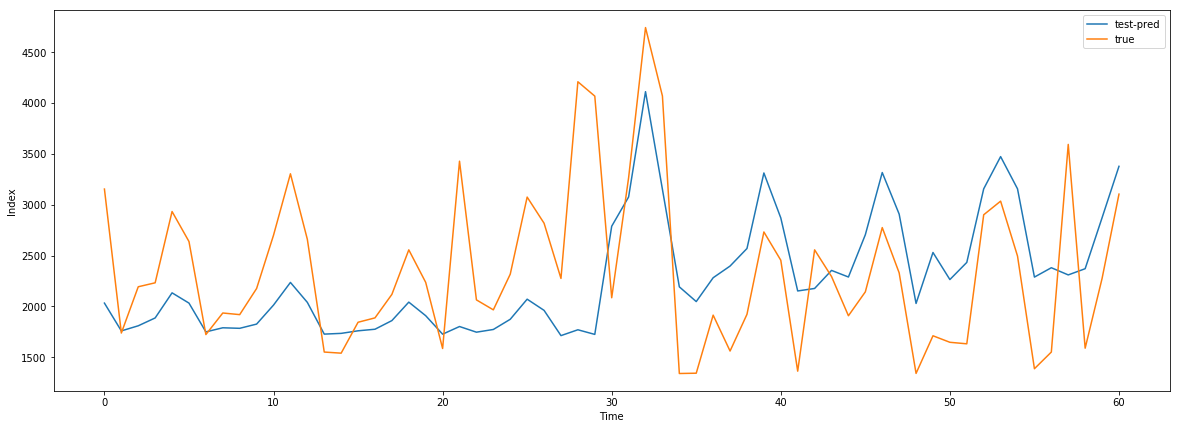

In [29]:
plt.figure(figsize=(20, 7))
plt.xlabel('Time')
plt.ylabel('Index')
plt.plot(test_pred, label='test-pred')
plt.plot(test_true, label='true')
plt.legend()
plt.show()

In [33]:
test_MSE=np.mean((test_true- test_pred)**2)
test_MSE

902375.8558262703

In [34]:
train_pred = model.predict(np.array(train_x).reshape(-1,15,1))


In [35]:
train_pred=x_scaler.inverse_transform(train_pred)
train_true =x_scaler.inverse_transform(train_y)

/Users/shihongliang/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


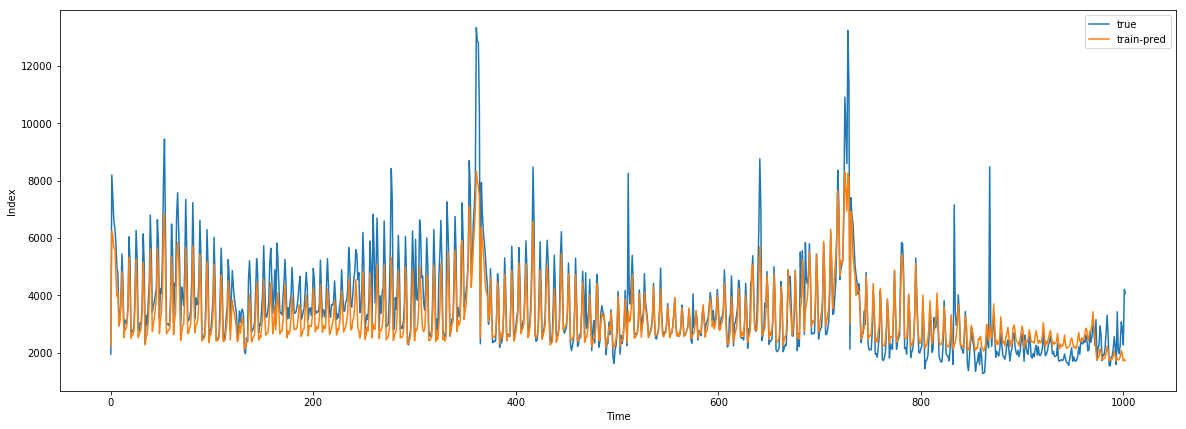

In [37]:
plt.figure(figsize=(20, 7))
plt.xlabel('Time')
plt.ylabel('Index')

plt.plot(train_true, label='true')
plt.plot(train_pred, label='train-pred')
plt.legend()
plt.show()

In [38]:
train_MSE=np.mean((train_true- train_pred)**2)
train_MSE

3754519.1838413575